# Test model with simple linear regression

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger 
import tigerpy.bbvi as bbvi

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

rng = np.random.default_rng(42)

## Simulate data

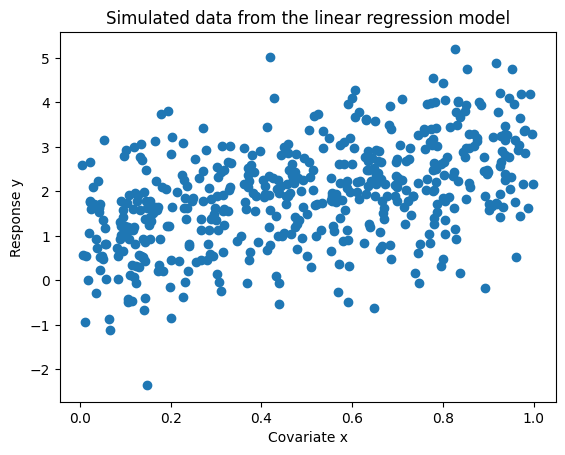

In [2]:
# sample size and true parameters

n = 500
true_beta = np.array([1.0, 2.0])
true_sigma = 1.0

# data-generating process

x0 = rng.uniform(size=n)
X_mat = np.column_stack([np.ones(n), x0])
eps = rng.normal(scale=true_sigma, size=n)
y_vec = X_mat @ true_beta + eps

# plot the simulated data

plt.scatter(x0, y_vec)
plt.title("Simulated data from the linear regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Set up model in tigerpy

In [3]:
# set up design matrix 
X = tiger.Obs(name = "X_loc")
X.fixed(X = x0)

# set up hyperparameters
beta_loc = tiger.Hyper(0, name="beta_loc")
beta_scale = tiger.Hyper(100, name="beta_scale")

# set up parameters 
beta_dist = tiger.Dist(tfd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="a")
sigma_b = tiger.Hyper(0.01, name="b")

sigma_dist = tiger.Dist(tfd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, function=jnp.exp, name="sigma")

# set up the linear predictor 
lpred = tiger.Lpred(X=X, name="loc", beta=beta)

# set up response distribution
y_dist = tiger.Dist(tfd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(y=y_vec, distribution=y_dist)

In [4]:
m.log_lik

Array([-3.3007705, -3.240914 , -3.2759068, -3.248854 , -3.2267048,
       -3.2451065, -3.2651124, -3.236326 , -3.2399905, -3.2661066,
       -3.2437449, -3.2544785, -3.2591083, -3.2488282, -3.2613528,
       -3.2222342, -3.2372513, -3.225249 , -3.228254 , -3.2873063,
       -3.2797108, -3.22642  , -3.231876 , -3.2216828, -3.24179  ,
       -3.2940927, -3.2495687, -3.2229178, -3.2372532, -3.224765 ,
       -3.2455525, -3.2675645, -3.2337785, -3.253572 , -3.2476015,
       -3.2424803, -3.2231567, -3.2621143, -3.2690406, -3.230901 ,
       -3.2263908, -3.3015695, -3.2459264, -3.2673845, -3.2462099,
       -3.3041277, -3.2396963, -3.2383578, -3.2987368, -3.225735 ,
       -3.2225757, -3.2231264, -3.2673128, -3.2244418, -3.2679691,
       -3.24198  , -3.2685146, -3.2218535, -3.2227392, -3.22257  ,
       -3.232933 , -3.245501 , -3.2405605, -3.2474387, -3.2437897,
       -3.2482169, -3.2276828, -3.2483141, -3.2363899, -3.2470272,
       -3.2412388, -3.2438576, -3.3339508, -3.2310567, -3.2248

In [5]:
m.log_prior

Array(-18.020359, dtype=float32)

In [6]:
m.log_prob

Array(-1641.4343, dtype=float32)

In [7]:
sample = dict(beta=jnp.array([5,7], dtype=jnp.float32), scale=jnp.array([20], dtype=jnp.float32))

m.update_graph(sample=sample)

Array(-2004.7633, dtype=float32)

## Setting everything up for the BBVI

In [14]:
key = jax.random.PRNGKey(27)

q = bbvi.Bbvi(Model=m, num_samples=1000, num_iterations=1000, seed=key)

q.variational_params

{'beta': {'mu': Array([0., 0.], dtype=float32),
  'cov': Array([0., 0.], dtype=float32)},
 'scale': {'mu': Array([0.], dtype=float32),
  'cov': Array([0.], dtype=float32)}}

In [15]:
q.lower_bound(q.variational_params)

Array(10864.119, dtype=float32)

In [16]:
q.lower_bound(q.variational_params)
q.logprob(q.samples)

Array([  -871.1708 ,  -2029.7651 ,  -1509.2202 ,  -2090.2231 ,
        -1614.2665 ,   -887.78735,  -1130.6338 ,   -935.4075 ,
        -1116.3057 ,  -2271.0352 ,  -1083.7437 ,  -1106.2112 ,
        -1165.5381 ,  -1258.4578 ,  -1117.807  ,  -3702.358  ,
        -1503.6858 ,  -1148.5336 ,  -2670.3528 ,  -1401.9205 ,
        -1068.1152 ,  -1549.6476 ,  -2098.7607 ,  -1110.2648 ,
        -1137.2931 ,  -1437.8363 ,  -1640.7087 ,  -1131.5739 ,
        -1515.8062 ,  -1362.2668 ,  -1678.4675 ,  -1638.1628 ,
        -1149.269  ,  -1489.2352 ,  -1349.2118 ,  -1640.5977 ,
        -1312.4125 ,  -3351.7678 ,   -894.3653 ,  -1428.0583 ,
        -2401.547  ,  -1186.3888 ,  -1221.9092 ,  -1145.3955 ,
        -1960.5477 ,  -1332.5479 ,  -2445.1016 ,   -908.9232 ,
        -1256.4132 ,  -1378.9106 ,  -1373.69   ,  -1275.1953 ,
        -3437.3528 ,  -1498.36   ,  -1758.1395 ,   -973.3042 ,
        -1205.0516 ,   -797.1    ,  -1690.727  ,  -1635.3131 ,
        -2219.226  ,   -942.8645 ,  -2469.4568 ,  -3097

In [17]:
q.run_bbvi()

(Array(767.78687, dtype=float32),
 {'beta': {'cov': Array([-4.5314474, -4.1963596], dtype=float32),
   'mu': Array([0.98575294, 1.9012077 ], dtype=float32)},
  'scale': {'cov': Array([-3.1126392], dtype=float32),
   'mu': Array([0.06861883], dtype=float32)}})

In [18]:
q.ELBO

Array([-10864.119  ,  -8609.563  ,  -6897.079  ,  -5598.253  ,
        -4612.02   ,  -3860.6428 ,  -3285.3547 ,  -2842.2217 ,
        -2498.5776 ,  -2230.1929 ,  -2019.0728 ,  -1851.8109 ,
        -1718.371  ,  -1611.1954 ,  -1524.5583 ,  -1454.0906 ,
        -1396.436  ,  -1348.9985 ,  -1309.7568 ,  -1277.1262 ,
        -1249.8568 ,  -1226.9563 ,  -1207.6333 ,  -1191.2517 ,
        -1177.2991 ,  -1165.3593 ,  -1155.0939 ,  -1146.226  ,
        -1138.5275 ,  -1131.811  ,  -1125.9211 ,  -1120.7286 ,
        -1116.1263 ,  -1112.0243 ,  -1108.347  ,  -1105.0315 ,
        -1102.0242 ,  -1099.2802 ,  -1096.7616 ,  -1094.436  ,
        -1092.2758 ,  -1090.2577 ,  -1088.3618 ,  -1086.5713 ,
        -1084.8712 ,  -1083.2491 ,  -1081.6947 ,  -1080.1982 ,
        -1078.752  ,  -1077.3494 ,  -1075.9841 ,  -1074.6512 ,
        -1073.3467 ,  -1072.0662 ,  -1070.8066 ,  -1069.5653 ,
        -1068.3396 ,  -1067.1273 ,  -1065.9269 ,  -1064.7365 ,
        -1063.5548 ,  -1062.3806 ,  -1061.2128 ,  -1060

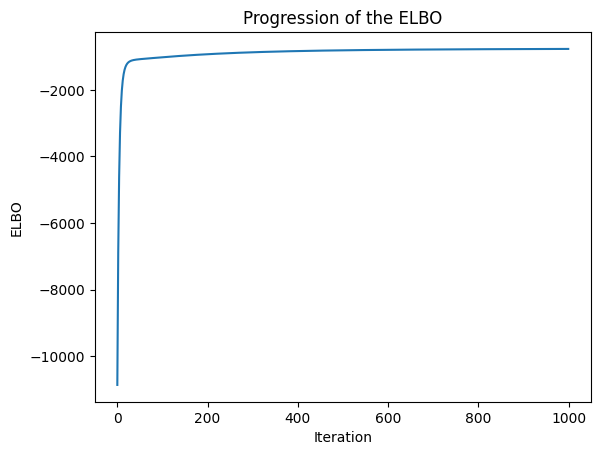

In [19]:
# visulaize the ELBO 
plt.plot(jnp.arange(q.num_iterations), q.ELBO)
plt.title("Progression of the ELBO")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()